In [1]:
!git clone https://github.com/Alfo5123/Variational-Sparse-Coding.git

Cloning into 'Variational-Sparse-Coding'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 1515 (delta 74), reused 65 (delta 28), pack-reused 1392
Receiving objects: 100% (1515/1515), 119.92 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [ ]:
import os
os.chdir('Variational-Sparse-Coding')

In [ ]:
os.makedirs('data/celeba', exist_ok=True)

In [4]:
from setup import download_CELEBA
download_CELEBA('data/celeba')

data/celeba/img_align_celeba.zip: 44.1kB [00:10, 4.26kB/s]


In [ ]:
shutil.rmtree('data/celeba/preprocessed64')

In [ ]:
from torchvision.transforms import CenterCrop, Resize
from PIL import Image

def preprocess(paths):
    base_path, target_path, file = paths
    downsample_size = 64
    img = Image.open(os.path.join(base_path, file))
    crop = CenterCrop(img.width)
    scale = Resize(downsample_size)
    img = scale(crop(img))
    img.save(os.path.join(target_path, file.replace('jpg', 'png')))

In [26]:
import os
from multiprocessing import Pool
from tqdm import tqdm

base_path = 'data/celeba/img_align_celeba'
target_path = 'data/celeba/preprocessed64'
os.makedirs(target_path, exist_ok=True)
files = os.listdir(base_path)
paths = [(base_path, target_path, f) for f in files]
pool = Pool()
processes = pool.imap_unordered(preprocess, paths)
iterator = tqdm(processes, total=len(paths))
for _ in iterator:
    pass
pool.close()
pool.join()

100%|██████████| 202599/202599 [13:12<00:00, 255.59it/s]


In [27]:
!ls data/celeba/preprocessed64 | head -n 5

000001.png
000002.png
000003.png
000004.png
000005.png


In [ ]:
img = Image.open('data/celeba/preprocessed64/000001.png')

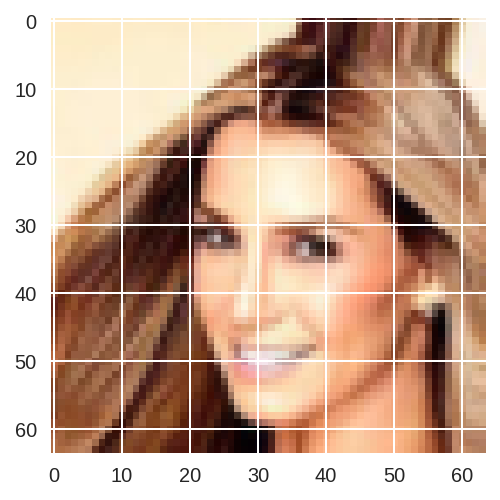

In [36]:

import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.array(img))

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore', '', UserWarning)

import torch
torch.manual_seed(1)
torch.cuda.manual_seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
dataset_params = {
    'dataset': 'celeba64',
    'batch_size': 32,
    'cuda': True,
    'root': 'data'
}

from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    **dataset_params)

Loading celeba64 dataset...
Done!



In [ ]:
images, _ = iter(test_loader).next()

In [39]:
images.shape

torch.Size([32, 3, 64, 64])

## Training

In [42]:
%%time
from src.models.conv_vsc import ConvolutionalVariationalSparseCoding

model_params = {
    'dataset': 'celeba64',
    'width': width,
    'height': height,
    'channels': channels,
    'kernel_szs': '32,32,64,64',
    'hidden_sz': 256,
    'latent_sz': 200,
    'learning_rate': 3e-4,
    
    'alpha': 0.1,
    'beta': 1.25,
    'beta_delta': 0,
    'c': 50,
    'c_delta': 1e-3, 
    
    'device': 'cuda',
    'log_interval': 1000,
    'normalize': False,
    'flatten': False
}

convvsc = ConvolutionalVariationalSparseCoding(**model_params)


CPU times: user 26 ms, sys: 6.32 ms, total: 32.3 ms
Wall time: 40.9 ms


In [43]:
%%time
training_params = { 
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 9, 
    'report_interval': 3,
    'sample_sz': 64,
    'reload_model': False,
    'checkpoints_path': 'results/checkpoints',
    'logs_path': 'results/logs',
    'images_path': 'results/images'
}

convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 9090.159180
Train Epoch: 1 [32000/100000 (32%)]	Loss: 6572.401367
Train Epoch: 1 [64000/100000 (64%)]	Loss: 6788.883789
Train Epoch: 1 [96000/100000 (96%)]	Loss: 6673.207520
====> Epoch: 1 Average loss: 6889.2335
====> Test set loss: 6684.3995 - VLB-ConvVSC : 213900.7831
Train Epoch: 2 [0/100000 (0%)]	Loss: 6623.539551
Train Epoch: 2 [32000/100000 (32%)]	Loss: 6464.974121
Train Epoch: 2 [64000/100000 (64%)]	Loss: 6375.833984
Train Epoch: 2 [96000/100000 (96%)]	Loss: 6426.078613
====> Epoch: 2 Average loss: 6622.1766
====> Test set loss: 6596.6429 - VLB-ConvVSC : 211092.5734
Train Epoch: 3 [0/100000 (0%)]	Loss: 6508.603516
Train Epoch: 3 [32000/100000 (32%)]	Loss: 6313.687500
Train Epoch: 3 [64000/100000 (64%)]	Loss: 6687.423340
Train Epoch: 3 [96000/100000 (96%)]	Loss: 6885.033203
====> Epoch: 3 Average loss: 6586.6737
====> Test set loss: 6574.4608 - VLB-ConvVSC : 210382.7453
Train Epoch: 4 [0/100000 (0%)]	Loss: 6351.24707

In [52]:
%%time
training_params = { 
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 3, 
    'report_interval': 3,
    'sample_sz': 64,
    'reload_model': False,
    'checkpoints_path': 'results/checkpoints',
    'logs_path': 'results/logs',
    'images_path': 'results/images'
}

convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 6194.287109
Train Epoch: 1 [32000/100000 (32%)]	Loss: 6431.774902
Train Epoch: 1 [64000/100000 (64%)]	Loss: 6445.152832
Train Epoch: 1 [96000/100000 (96%)]	Loss: 6449.350098
====> Epoch: 1 Average loss: 6519.7876
====> Test set loss: 6522.1696 - VLB-ConvVSC : 208709.4270
Train Epoch: 2 [0/100000 (0%)]	Loss: 6555.235840
Train Epoch: 2 [32000/100000 (32%)]	Loss: 6492.703125
Train Epoch: 2 [64000/100000 (64%)]	Loss: 6608.622070
Train Epoch: 2 [96000/100000 (96%)]	Loss: 6758.712402
====> Epoch: 2 Average loss: 6516.4391
====> Test set loss: 6518.3396 - VLB-ConvVSC : 208586.8681
Train Epoch: 3 [0/100000 (0%)]	Loss: 6264.746582
Train Epoch: 3 [32000/100000 (32%)]	Loss: 6645.173340
Train Epoch: 3 [64000/100000 (64%)]	Loss: 6599.505371
Train Epoch: 3 [96000/100000 (96%)]	Loss: 6781.395508
====> Epoch: 3 Average loss: 6513.0651
====> Test set loss: 6516.9514 - VLB-ConvVSC : 208542.4439
CPU times: user 3min 36s, sys: 28.3 s, total: 4

In [58]:
%%time
training_params = { 
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 3, 
    'report_interval': 3,
    'sample_sz': 64,
    'reload_model': False,
    'checkpoints_path': 'results/checkpoints',
    'logs_path': 'results/logs',
    'images_path': 'results/images'
}

convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 6605.401367
Train Epoch: 1 [32000/100000 (32%)]	Loss: 6730.142090
Train Epoch: 1 [64000/100000 (64%)]	Loss: 6699.377441
Train Epoch: 1 [96000/100000 (96%)]	Loss: 6396.356445
====> Epoch: 1 Average loss: 6509.8767
====> Test set loss: 6510.8530 - VLB-ConvVSC : 208347.2957
Train Epoch: 2 [0/100000 (0%)]	Loss: 6177.573242
Train Epoch: 2 [32000/100000 (32%)]	Loss: 6712.281250
Train Epoch: 2 [64000/100000 (64%)]	Loss: 6490.413086
Train Epoch: 2 [96000/100000 (96%)]	Loss: 6394.176270
====> Epoch: 2 Average loss: 6507.3227
====> Test set loss: 6509.8929 - VLB-ConvVSC : 208316.5715
Train Epoch: 3 [0/100000 (0%)]	Loss: 6837.918457
Train Epoch: 3 [32000/100000 (32%)]	Loss: 6293.023438
Train Epoch: 3 [64000/100000 (64%)]	Loss: 6822.282715
Train Epoch: 3 [96000/100000 (96%)]	Loss: 6456.574707
====> Epoch: 3 Average loss: 6504.9015
====> Test set loss: 6507.2860 - VLB-ConvVSC : 208233.1535
CPU times: user 3min 55s, sys: 29.5 s, total: 4

In [ ]:
torch.save(convvsc.model.state_dict(), 
           'results/convvsc_celeba_9e_200z.pth')

In [ ]:
torch.save(convvsc.model.state_dict(), 
           'results/convvsc_celeba_12e_200z.pth')

In [ ]:
torch.save(convvsc.model.state_dict(), 
           'results/convvsc_celeba_15e_200z.pth')

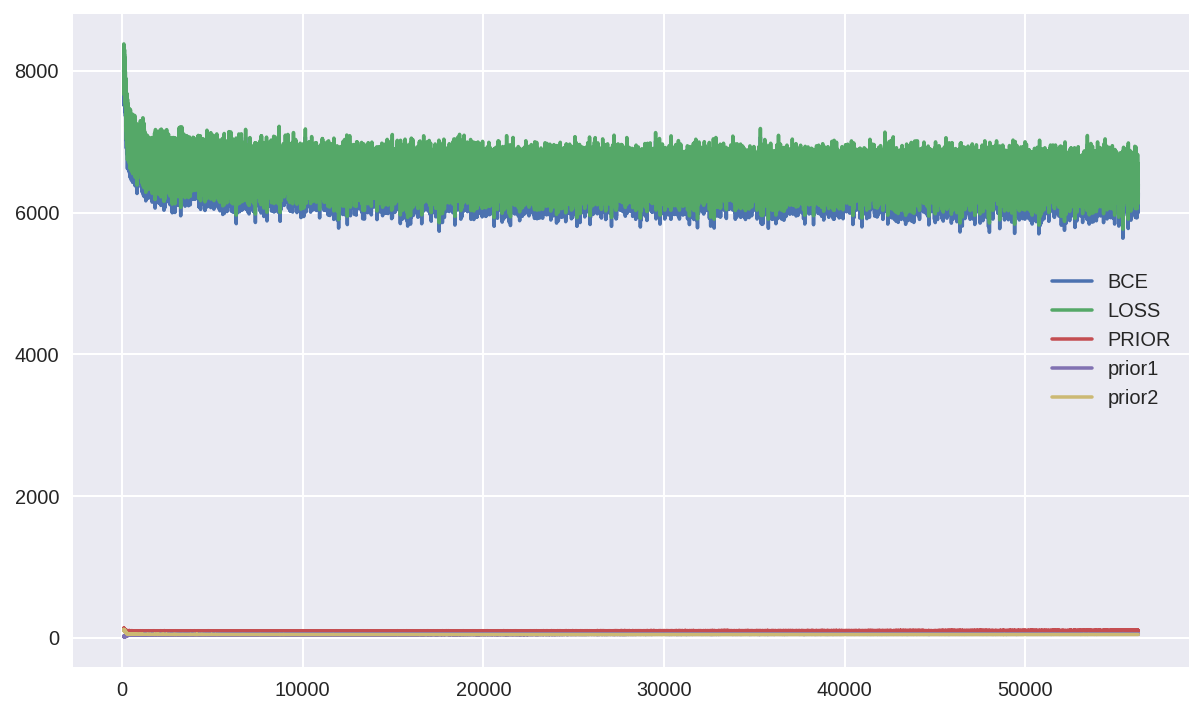

In [60]:
import pandas as pd
train = pd.DataFrame(convvsc.train_losses)
(train / dataset_params['batch_size']).iloc[100:].plot(figsize=(10,6));

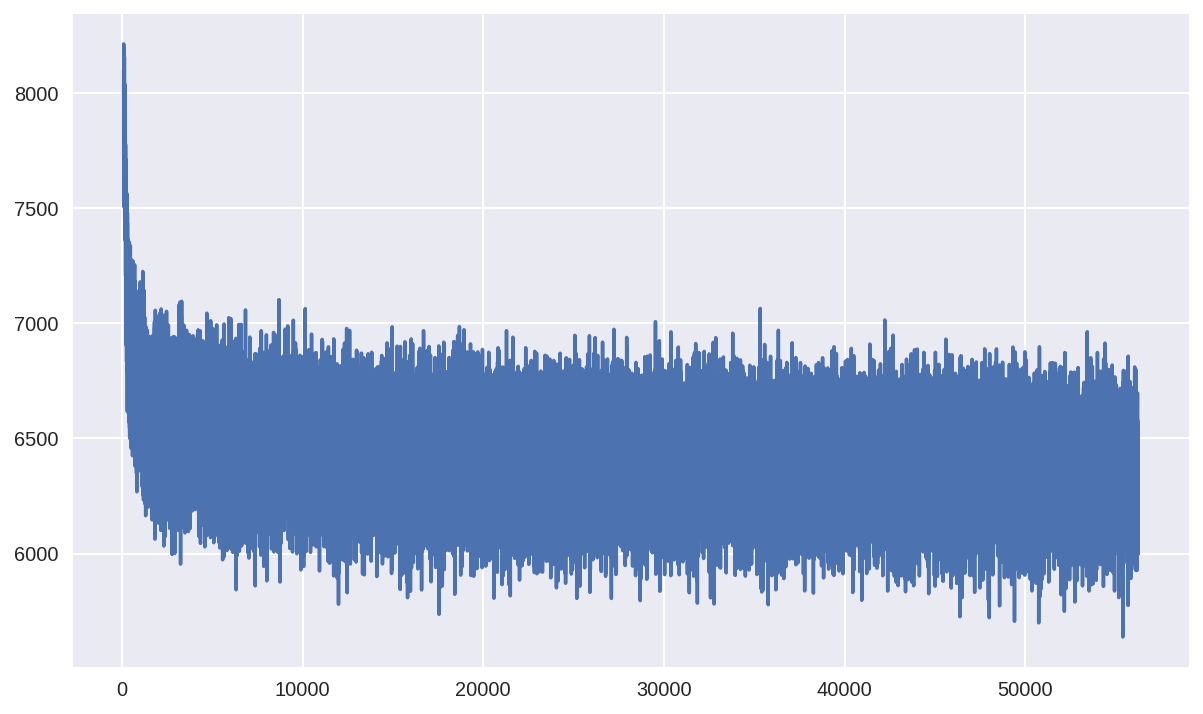

In [61]:
import pandas as pd
train = pd.DataFrame(convvsc.train_losses)
(train['BCE'] / dataset_params['batch_size']).iloc[100:].plot(figsize=(10,6));

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def plot_image(img, ax, title):
    ax.imshow(np.transpose(img, (1,2,0)) , interpolation='nearest')
    ax.set_title(title, fontsize=20)
    
def to_numpy(image, vsc):
    return torchvision.utils.make_grid(
        image.view(1, vsc.channels, vsc.height, vsc.width)
    ).cpu().detach().numpy()
    
def plot_encoding(image, vsc, latent_sz, alpha, width=1/7):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z = z.cpu().detach().numpy()[0]
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,4))
    
    plot_image(to_numpy(image, vsc), ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (latent_sz, alpha), fontsize=14)
    
    plot_image(to_numpy(img, vsc), ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

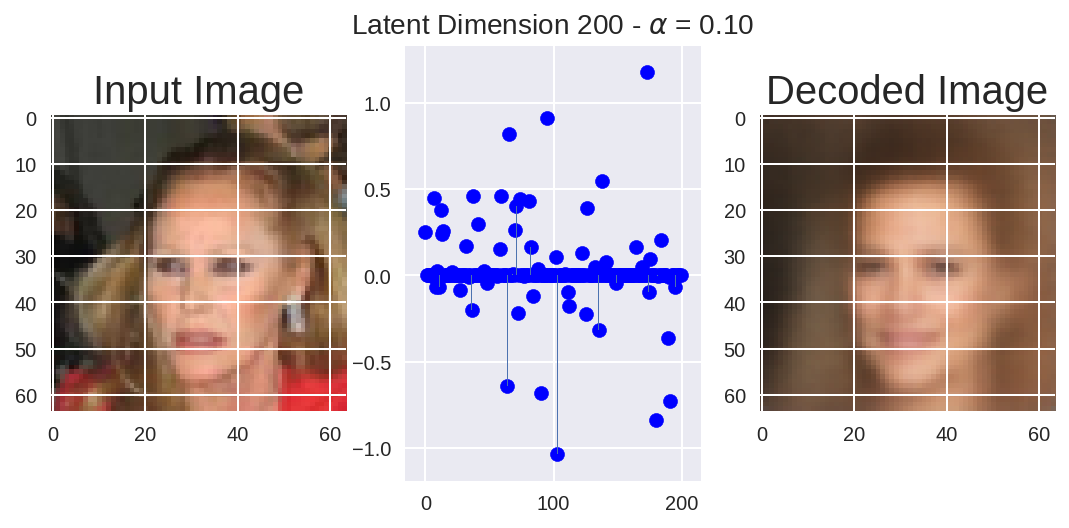

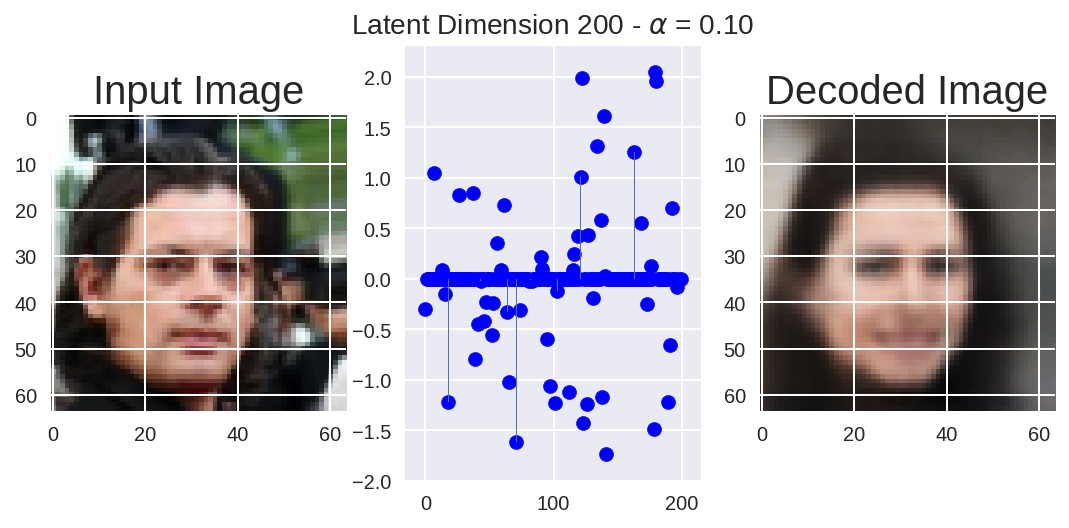

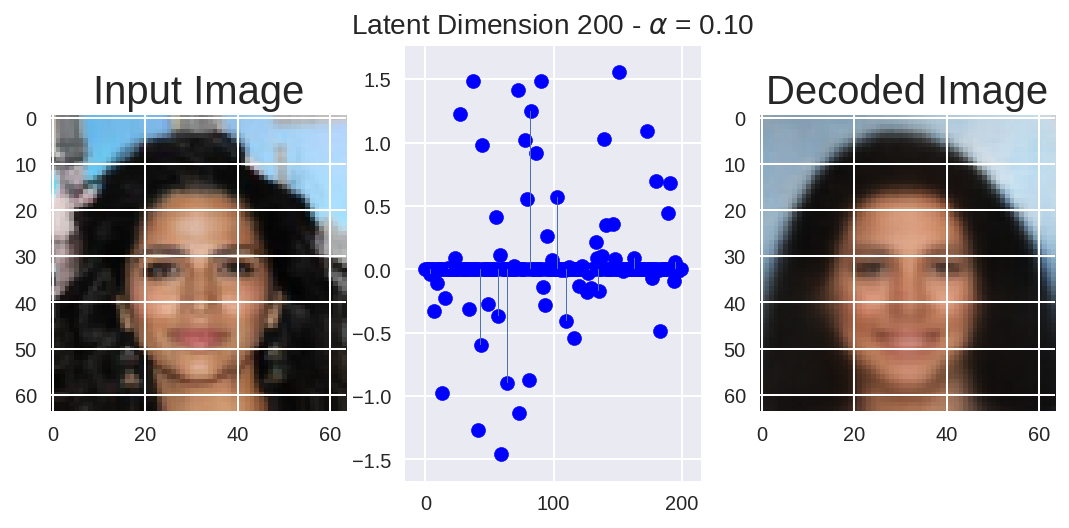

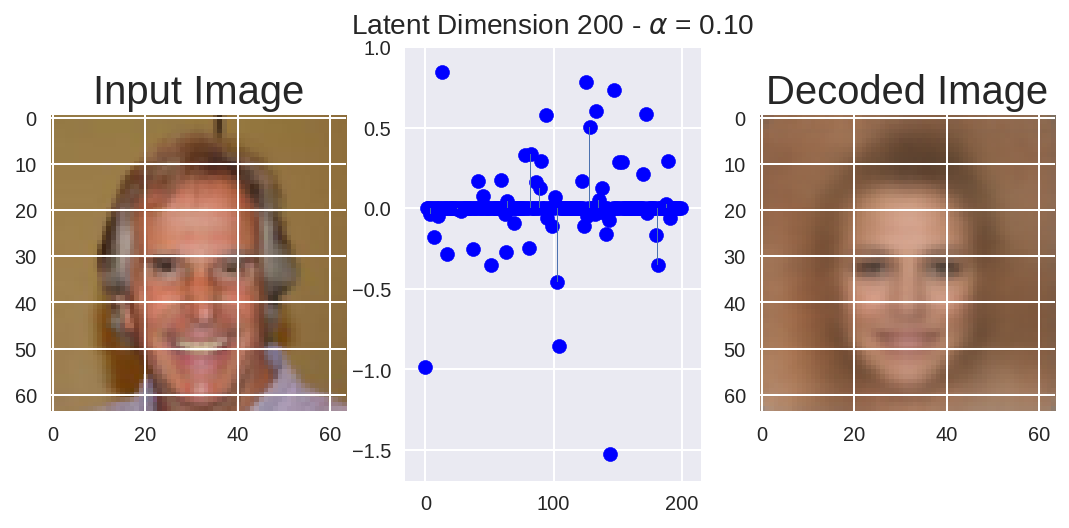

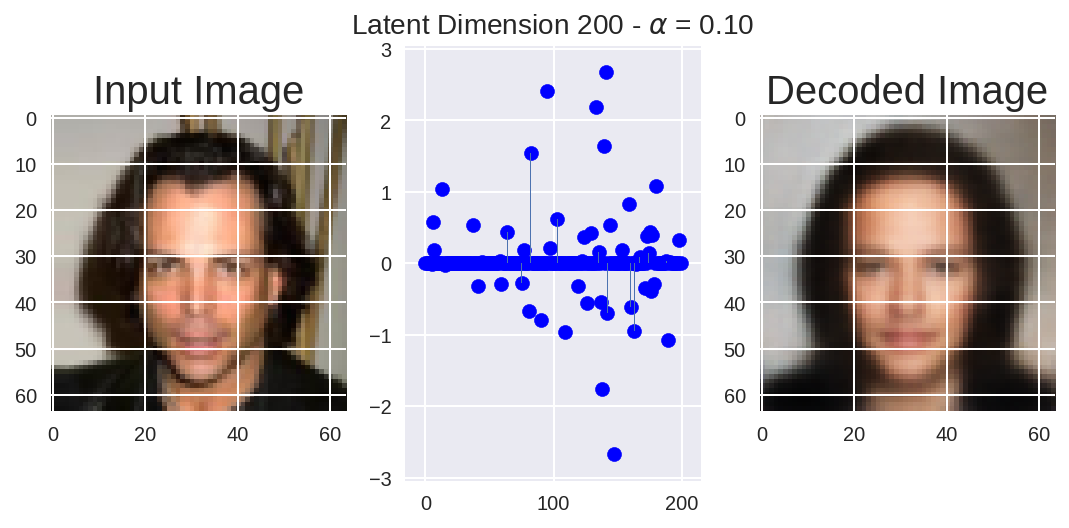

In [62]:
for i in range(5):
    plot_encoding(images[i][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])

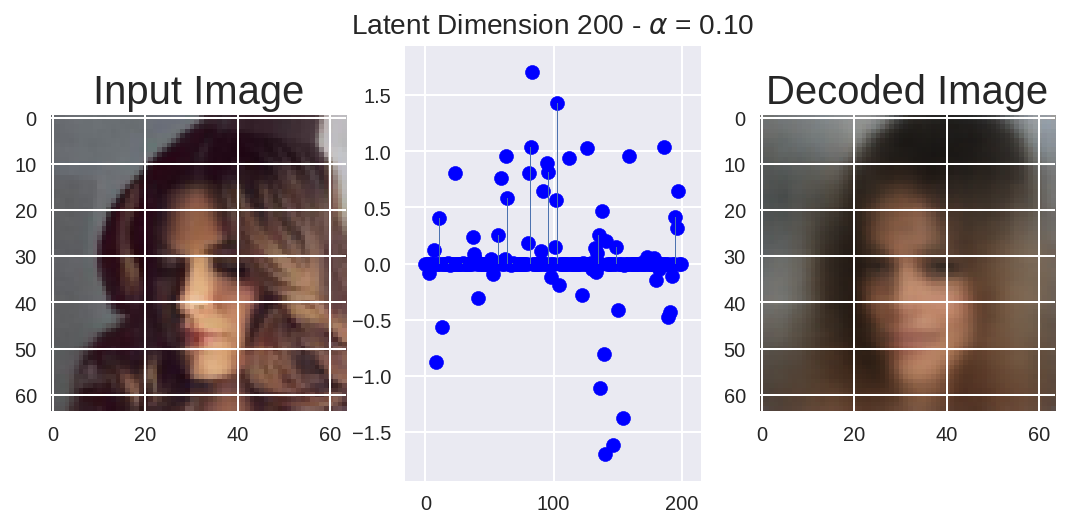

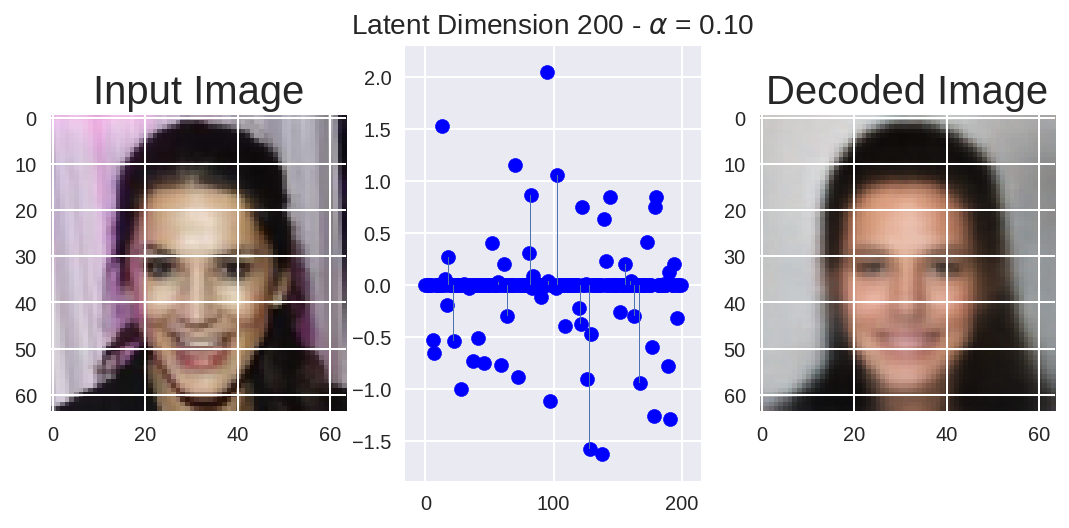

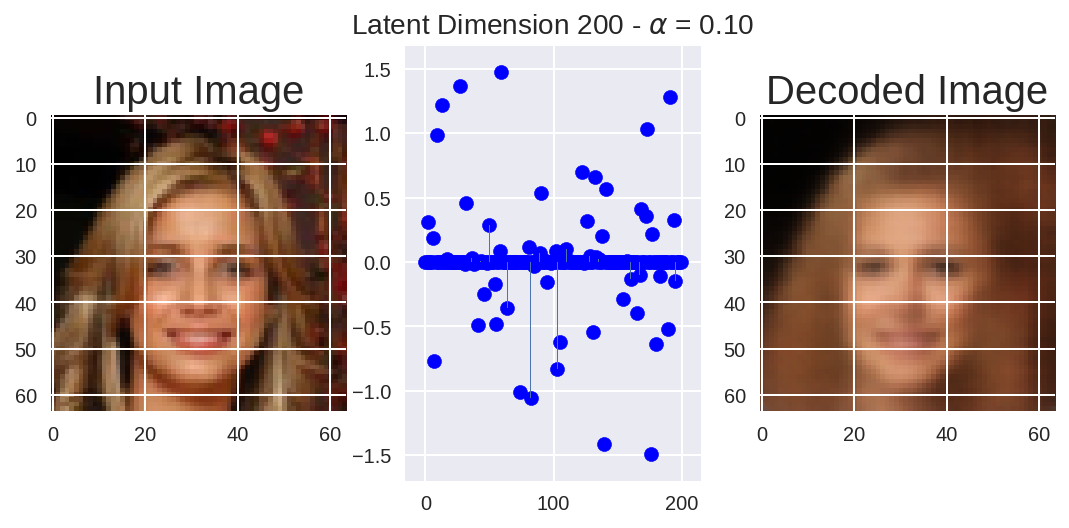

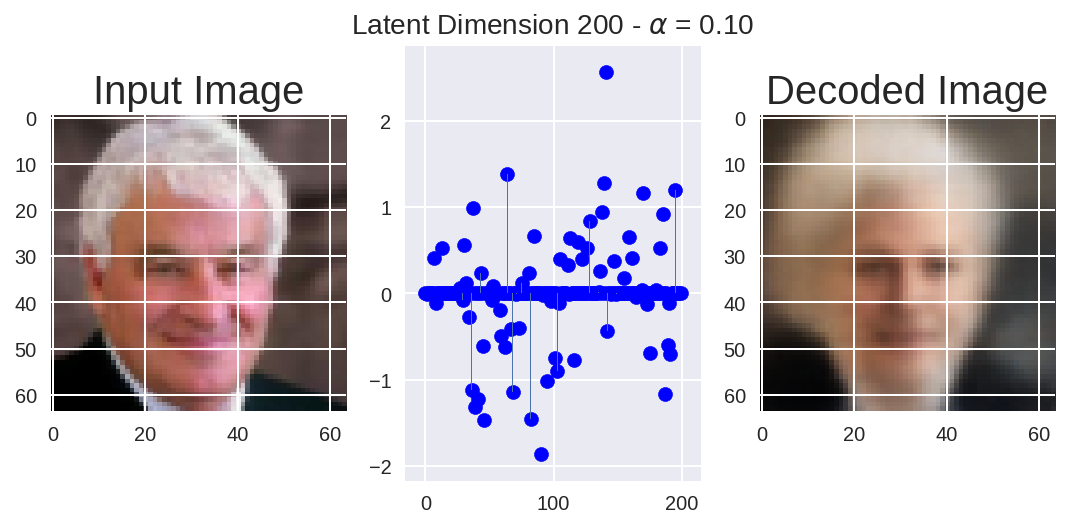

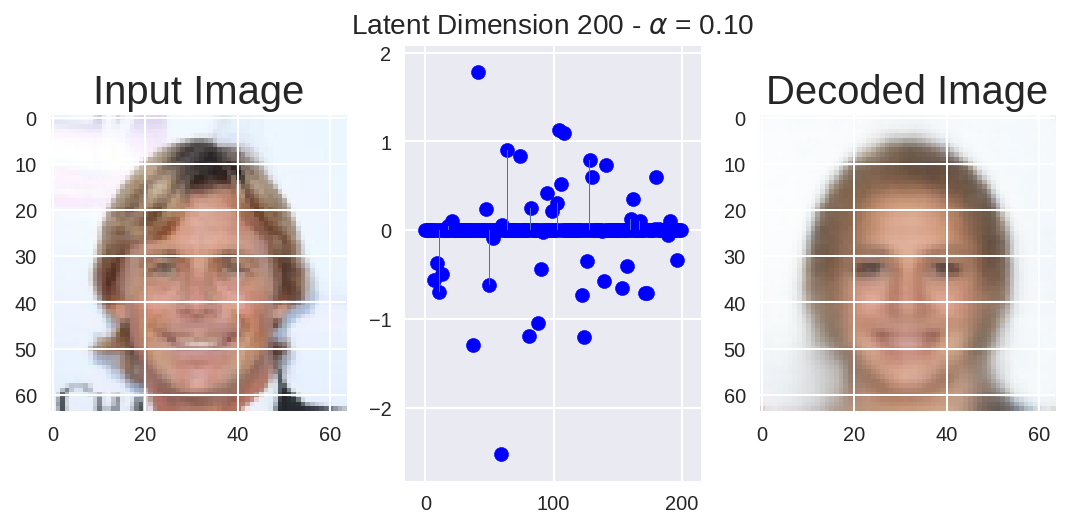

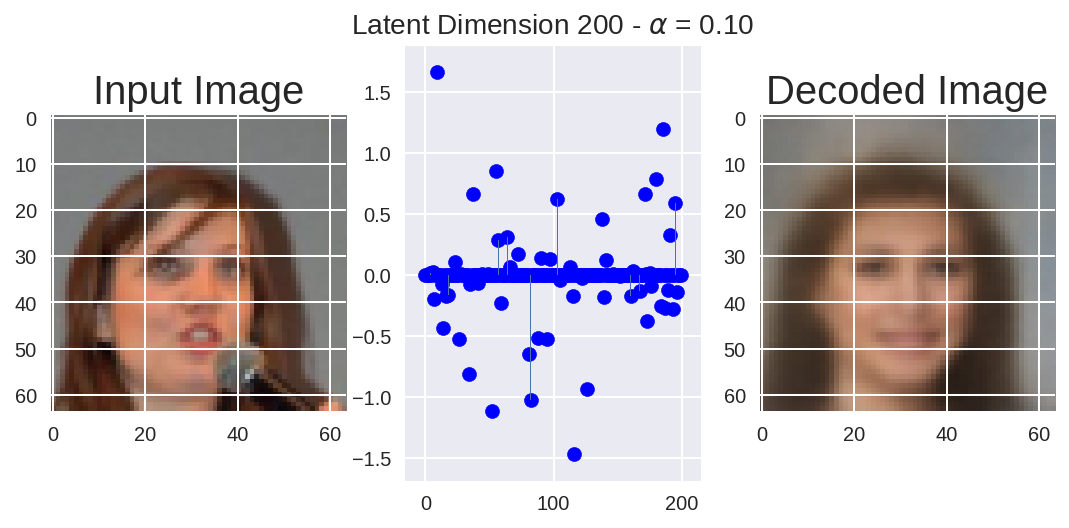

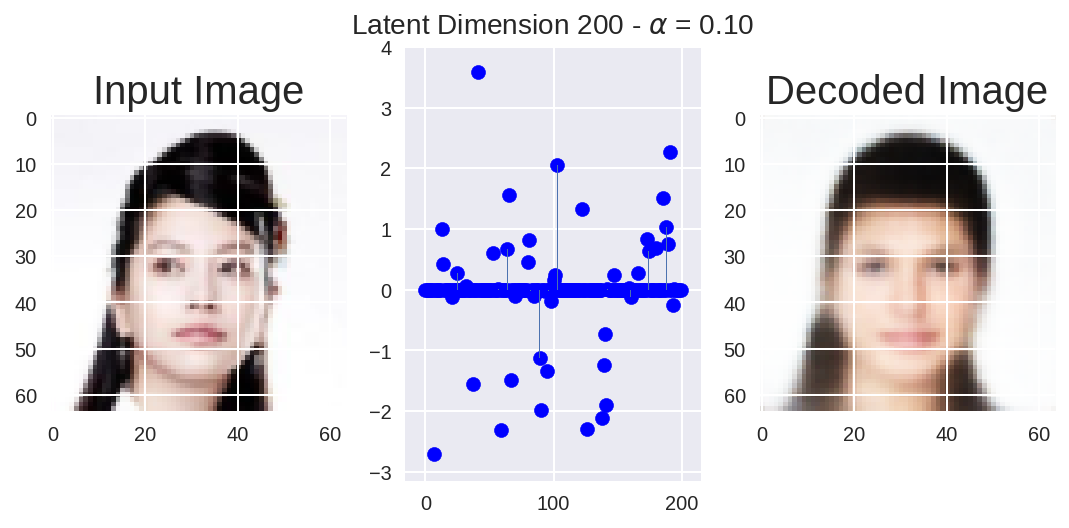

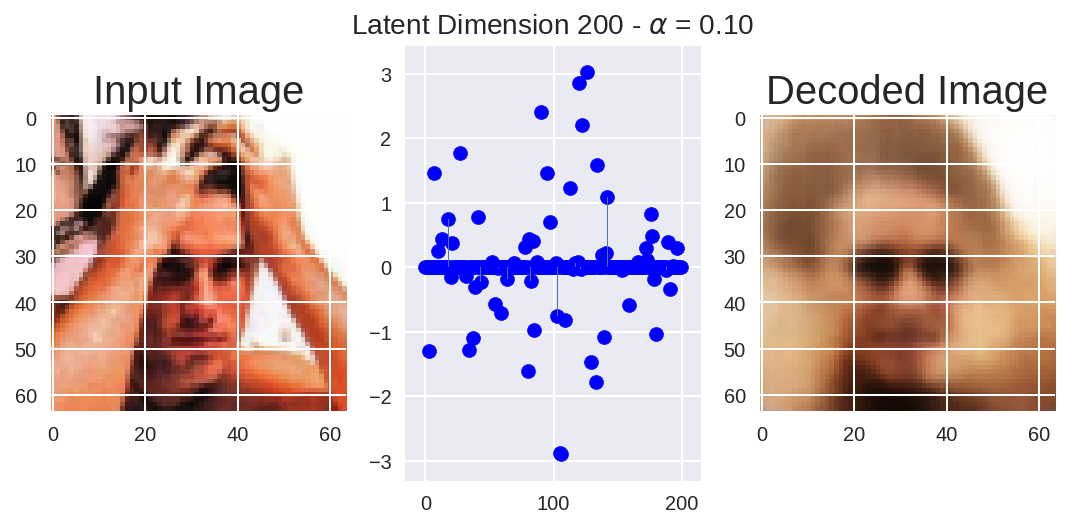

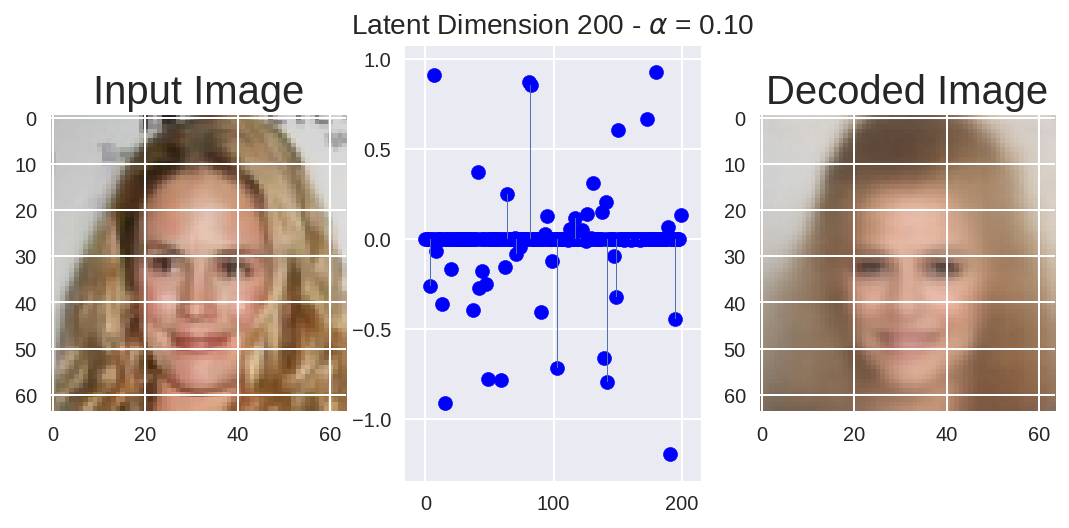

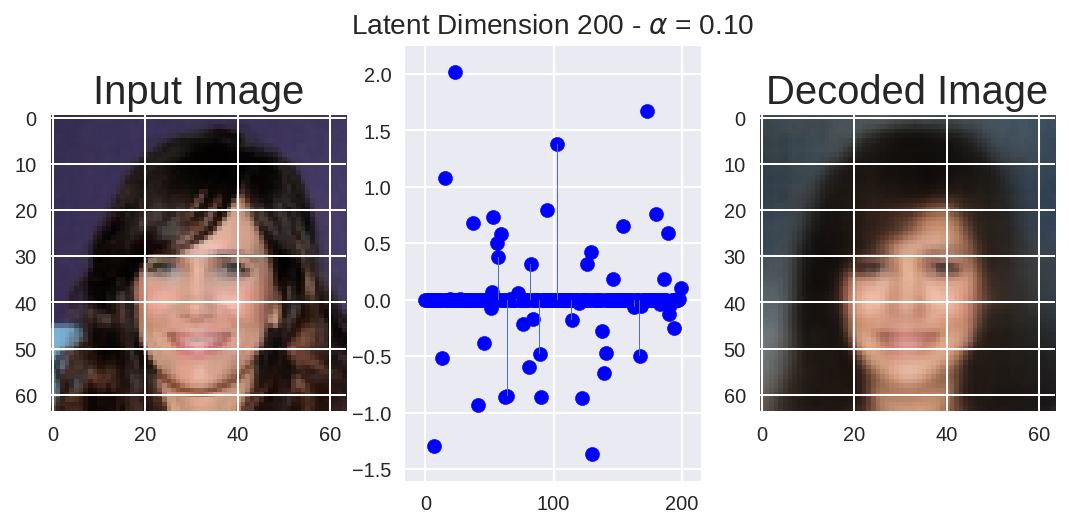

In [63]:
for i in range(10):
    plot_encoding(images[-i-1][None,:], convvsc, 
                  model_params['latent_sz'], 
                  model_params['alpha'])